In [2]:
# Cell: Cài đặt Kaggle và Cấu hình Token (SỬA LẠI DÒNG cp)

# Cài đặt thư viện Kaggle
!pip install -q kaggle

# Tạo thư mục .kaggle
!mkdir -p ~/.kaggle

# Di chuyển file kaggle.json TỪ /content/ vào ~/.kaggle/
!cp /content/kaggle.json ~/.kaggle/ # <-- SỬA THÀNH DÒNG NÀY

# Đặt quyền
!chmod 600 ~/.kaggle/kaggle.json

# Kiểm tra (tùy chọn)
!ls -l ~/.kaggle/kaggle.json

print("Kaggle API token configured.")

-rw------- 1 root root 66 Apr 23 06:57 /root/.kaggle/kaggle.json
Kaggle API token configured.


In [4]:
# Cell: Tải và Giải nén Dataset (ĐÃ SỬA ĐƯỜNG DẪN GIẢI NÉN)

# Lệnh tải dataset (giữ nguyên)
!kaggle datasets download -d atulyakumar98/test-dataset

print("Dataset download command executed.")

# Giải nén file zip
import zipfile
zip_file_path = 'test-dataset.zip' # <-- Kiểm tra lại tên file zip này nếu cần

# --- THAY ĐỔI ĐƯỜNG DẪN GIẢI NÉN ---
# Giải nén vào thư mục /content/test-dataset thay vì /kaggle/input/
extract_path = '/content/test-dataset'
# ----------------------------------

# Tạo thư mục đích (trong /content/ nơi bạn có quyền ghi)
!mkdir -p {extract_path}

# Giải nén vào thư mục mới
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset successfully extracted to {extract_path}")
    # Xóa file zip sau khi giải nén (tùy chọn)
    !rm {zip_file_path}
except FileNotFoundError:
    print(f"Error: Zip file '{zip_file_path}' not found. Check the downloaded file name.")
    # In ra danh sách file trong thư mục hiện tại để kiểm tra
    !ls -l
except Exception as e:
    print(f"Error during extraction: {e}")

# Kiểm tra nội dung thư mục sau khi giải nén
print("\nContents of extraction directory:")
!ls -l {extract_path}
print(f"\nContents of {extract_path}/Fire-Detection:")
!ls -l {extract_path}/Fire-Detection # Kiểm tra thư mục chứa ảnh

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/test-dataset
License(s): unknown
test-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset download command executed.
Dataset successfully extracted to /content/test-dataset

Contents of extraction directory:
total 4
drwxr-xr-x 4 root root 4096 Apr 23 06:59 Fire-Detection

Contents of /content/test-dataset/Fire-Detection:
total 24
drwxr-xr-x 2 root root 20480 Apr 23 06:59 0
drwxr-xr-x 2 root root  4096 Apr 23 06:59 1


In [5]:
# Cell 1: Cài đặt và Imports

# !pip install kagglehub # Bỏ comment nếu cần cài đặt

# Ignore warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import pathlib
import os
import random as rn
import shutil
from tqdm import tqdm
from PIL import Image

# Configure plotting style
%matplotlib inline
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Sẽ dùng sau nếu cần augment phức tạp hơn
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50 # Hoặc EfficientNetV2B0, etc.
from tensorflow.keras.applications.resnet50 import preprocess_input # QUAN TRỌNG: Import hàm tiền xử lý phù hợp

# Scikit-learn
from sklearn.model_selection import train_test_split # Dùng cách khác để chia data
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder # Không cần nếu dùng class_mode='binary' hoặc 'categorical' từ generator

# Reproducibility (optional)
# os.environ['PYTHONHASHSEED'] = '0'
# np.random.seed(42)
# rn.seed(12345)
# tf.random.set_seed(89)

print("Imports complete.")

Imports complete.


Class names: ['0' '1']
Total images found (approx): 651
Image counts per class: {np.str_('0'): 541, np.str_('1'): 110}


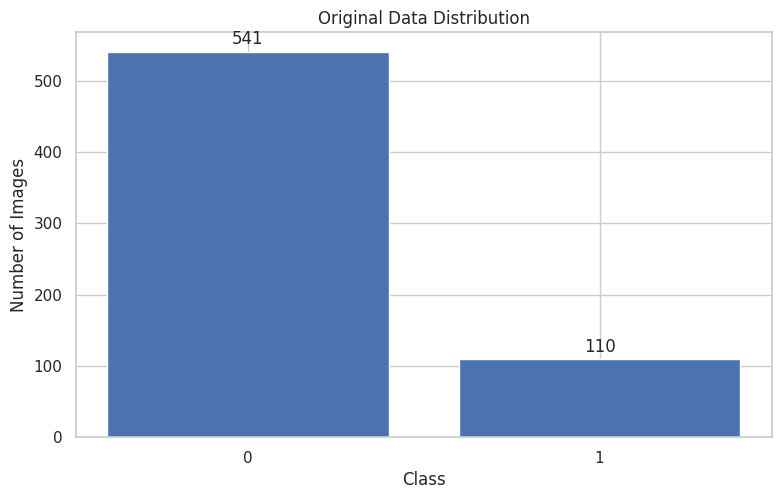

In [6]:
# Cell 2: Thiết lập Đường dẫn và Tham số

# --- Cấu hình ---
IMG_SIZE = 256  # Kích thước ảnh input cho model
BATCH_SIZE = 32 # Số lượng ảnh xử lý trong mỗi batch
EPOCHS_TOP_LAYER = 15 # Số epochs để huấn luyện lớp trên cùng
EPOCHS_FINE_TUNE = 10 # Số epochs để fine-tune (nếu thực hiện)
LEARNING_RATE = 1e-4 # Learning rate ban đầu (có thể thử 5e-5 hoặc 1e-3)
FINE_TUNE_LR = 1e-6 # Learning rate RẤT NHỎ khi fine-tune
DATASET_PATH = '/content/test-dataset/Fire-Detection' # Đường dẫn tới dataset đã download
MODEL_SAVE_PATH = '/kaggle/working/fire_detection_resnet50_v2.h5' # Nơi lưu model tốt nhất
# ----------------

data_dir = pathlib.Path(DATASET_PATH)

# Kiểm tra xem thư mục dữ liệu có tồn tại không
if not data_dir.exists():
    raise FileNotFoundError(f"Dataset directory not found at: {DATASET_PATH}")

# Lấy tên các lớp (thư mục con 0 và 1)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Class names:", class_names)
if len(class_names) != 2:
    print(f"Warning: Expected 2 classes (0 and 1), but found {len(class_names)}: {class_names}")

# Đếm tổng số ảnh (ước lượng)
try:
    image_count = len(list(data_dir.glob('*/*.[jJ][pP][gG]'))) + \
                  len(list(data_dir.glob('*/*.[jJ][pP][eE][gG]'))) + \
                  len(list(data_dir.glob('*/*.[pP][nN][gG]')))
    print(f"Total images found (approx): {image_count}")
    if image_count == 0:
       print("Warning: No image files found in the dataset directories. Check the path and file extensions.")
except Exception as e:
    print(f"Error counting images: {e}")


# Vẽ biểu đồ phân bố dữ liệu gốc (Optional)
try:
    counts = {}
    for class_name in class_names:
        class_dir = data_dir / class_name
        count = len(list(class_dir.glob('*.[jJ][pP][gG]'))) + \
                len(list(class_dir.glob('*.[jJ][pP][eE][gG]'))) + \
                len(list(class_dir.glob('*.[pP][nN][gG]')))
        counts[class_name] = count

    print("Image counts per class:", counts)

    plt.figure(figsize=(8, 5))
    plt.bar(counts.keys(), counts.values())
    plt.title('Original Data Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    for i, v in enumerate(counts.values()):
        plt.text(i, v + 10, str(v), ha='center')
    plt.show()
except Exception as e:
    print(f"Error generating plot: {e}")

Creating training dataset...
Found 651 files belonging to 2 classes.
Using 521 files for training.
Class names inferred by training dataset: ['0', '1']

Creating validation dataset...
Found 651 files belonging to 2 classes.
Using 130 files for validation.
Class names inferred by validation dataset: ['0', '1']

Final Class Names: ['0', '1']


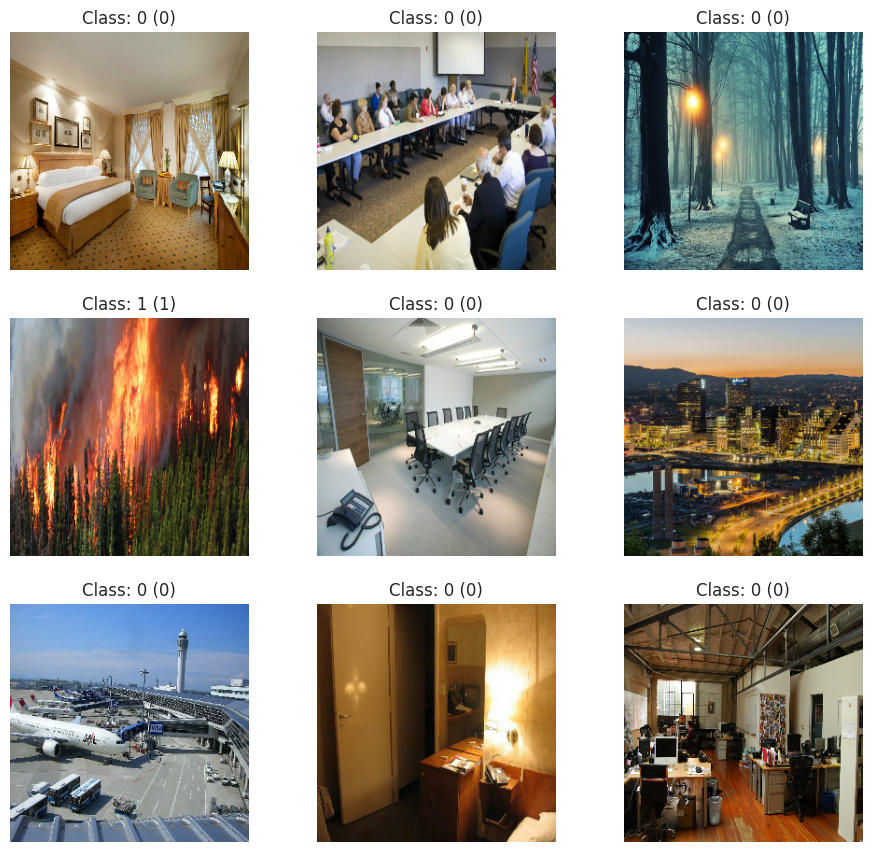

In [7]:
# Cell 3: Chuẩn bị Datasets (Sử dụng Keras Utilities)

# Chia dữ liệu thành tập huấn luyện (80%) và tập validation (20%)
# Tập test sẽ được tạo từ một phần của tập validation sau nếu cần,
# hoặc lý tưởng nhất là bạn nên có một thư mục test riêng biệt hoàn toàn.
# Hiện tại, chúng ta sẽ dùng tập validation để đánh giá trong quá trình huấn luyện.

print("Creating training dataset...")
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2, # Tách 20% làm validation
  subset="training",
  seed=123, # Đặt seed để việc tách dữ liệu nhất quán mỗi lần chạy
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='binary' # Sử dụng 'binary' cho 2 lớp (output là 0 hoặc 1)
)
print("Class names inferred by training dataset:", train_ds.class_names)


print("\nCreating validation dataset...")
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='binary' # Phải giống với train_ds
)
print("Class names inferred by validation dataset:", val_ds.class_names)

# Xác nhận tên lớp khớp nhau
if train_ds.class_names != val_ds.class_names:
    raise ValueError("Class names mismatch between training and validation sets!")
CLASS_NAMES_INFERRED = train_ds.class_names
print("\nFinal Class Names:", CLASS_NAMES_INFERRED) # Sẽ là ['0', '1']

# Bạn có thể tạo tập Test từ tập Validation nếu muốn
# val_batches = tf.data.experimental.cardinality(val_ds)
# test_ds = val_ds.take(val_batches // 2)
# val_ds = val_ds.skip(val_batches // 2)
# print(f"\nValidation dataset size: {tf.data.experimental.cardinality(val_ds).numpy()} batches")
# print(f"Test dataset size: {tf.data.experimental.cardinality(test_ds).numpy()} batches")

# Hiển thị một vài ảnh từ tập huấn luyện để kiểm tra
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Lấy 1 batch
  for i in range(9): # Hiển thị 9 ảnh đầu tiên
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f"Class: {int(labels[i].numpy())} ({CLASS_NAMES_INFERRED[int(labels[i].numpy())]})")
    plt.axis("off")
plt.show()

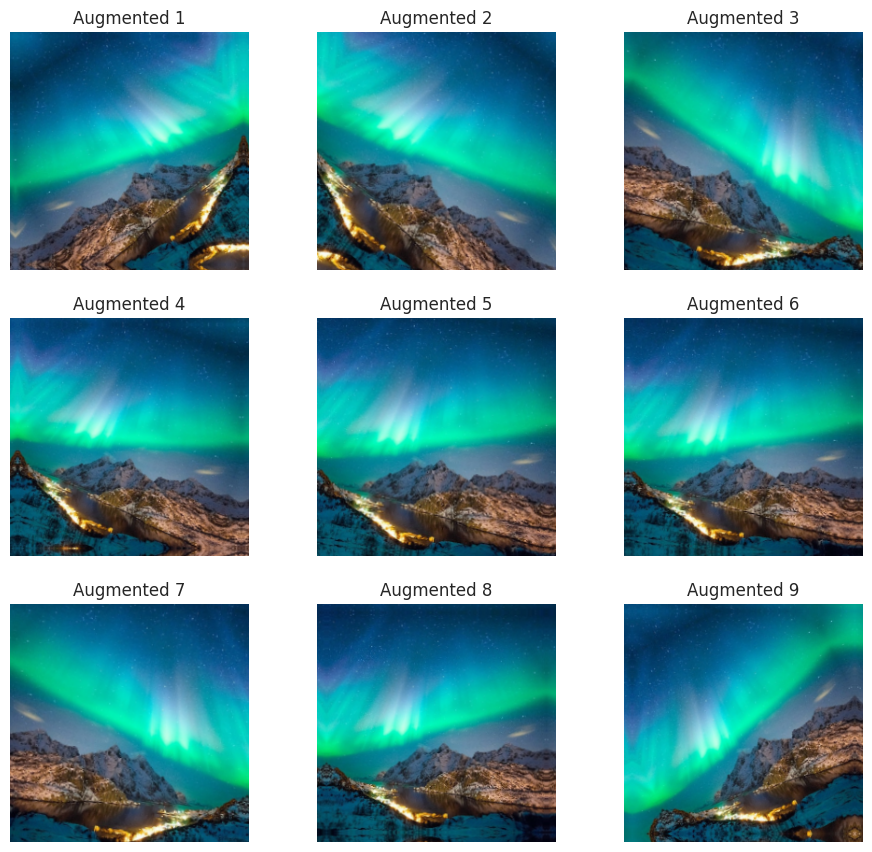

In [8]:
# Cell 4: Data Augmentation Layer

# Định nghĩa các phép tăng cường dữ liệu cơ bản
# Bỏ Histogram Equalization, thay bằng các phép phổ biến hơn
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"), # Lật ảnh ngẫu nhiên theo chiều ngang
    layers.RandomRotation(0.1),      # Xoay ảnh ngẫu nhiên một góc nhỏ
    layers.RandomZoom(0.1),         # Zoom ảnh ngẫu nhiên một chút
    # layers.RandomContrast(0.1),   # Thay đổi độ tương phản ngẫu nhiên (cẩn thận với ảnh cháy)
    # layers.RandomBrightness(0.1), # Thay đổi độ sáng ngẫu nhiên (cẩn thận với ảnh cháy)
  ],
  name="data_augmentation",
)

# Thử nghiệm augmentation trên một ảnh
for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    # Áp dụng augmentation (cần thêm batch dimension và bỏ đi sau đó)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(f"Augmented {i+1}")
    plt.axis("off")
  plt.show()
  break # Chỉ cần thử với batch đầu tiên

In [9]:
# Cell 5: Configure Dataset Pipeline for Performance & Preprocessing

AUTOTUNE = tf.data.AUTOTUNE

# Hàm áp dụng tiền xử lý của ResNet50
def preprocess_image(image, label):
  image = preprocess_input(image) # Áp dụng tiền xử lý cần thiết
  return image, label

# Cấu hình pipeline cho tập train
train_ds = train_ds.cache().shuffle(1000) # Cache và shuffle
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Áp dụng augmentation
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE) # Áp dụng preprocess_input
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Prefetch để chuẩn bị batch tiếp theo

# Cấu hình pipeline cho tập validation (Không augmentation, chỉ preprocess)
val_ds = val_ds.cache()
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE) # Chỉ áp dụng preprocess_input
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# Cấu hình pipeline cho tập test (Nếu bạn đã tạo ở Cell 3)
# test_ds = test_ds.cache()
# test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
# test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("Dataset pipelines configured with augmentation (train only) and preprocessing.")

Dataset pipelines configured with augmentation (train only) and preprocessing.


In [10]:
# Cell 6: Xây dựng Model (Transfer Learning)

# Định nghĩa input shape
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Load base model (ResNet50) - đóng băng các lớp gốc
base_model = ResNet50(include_top=False, # Bỏ lớp phân loại cuối cùng của ResNet50
                      weights='imagenet', # Load trọng số đã huấn luyện trên ImageNet
                      input_tensor=inputs,
                      pooling='avg') # Sử dụng Global Average Pooling

# Đóng băng base model để không huấn luyện lại các trọng số gốc ở giai đoạn đầu
base_model.trainable = False

# Xây dựng model mới trên nền tảng base model
# Không cần thêm lớp augmentation ở đây nữa vì đã áp dụng trong pipeline dữ liệu
x = base_model.output
# Thêm các lớp Dense tùy chỉnh
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Thêm Dropout để giảm overfitting
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Lớp output cho phân loại nhị phân (0 hoặc 1)
outputs = Dense(1, activation='sigmoid')(x) # Sigmoid cho binary classification

# Tạo model hoàn chỉnh
model = Model(inputs, outputs)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
# Cell 7: Compile Model (Giai đoạn 1 - Huấn luyện lớp trên cùng)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy', # Loss phù hợp cho output sigmoid
              metrics=['accuracy'])

print("Model compiled for training top layers.")

Model compiled for training top layers.


In [12]:
# Cell 8: Định nghĩa Callbacks

# Callback để lưu model tốt nhất dựa trên val_accuracy
checkpoint_cb = ModelCheckpoint(MODEL_SAVE_PATH,
                                monitor='val_accuracy',
                                save_best_only=True,
                                save_weights_only=False, # Lưu cả kiến trúc và trọng số
                                verbose=1)

# Callback để giảm learning rate khi validation loss không cải thiện
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.2, # Giảm lr đi 5 lần
                                 patience=3,  # Chờ 3 epochs không cải thiện
                                 min_lr=1e-7,  # Lr tối thiểu
                                 verbose=1)

# Callback để dừng huấn luyện sớm nếu không có cải thiện đáng kể
early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  patience=5, # Chờ 5 epochs không cải thiện
                                  restore_best_weights=True, # Khôi phục trọng số tốt nhất
                                  verbose=1)

callbacks_list = [checkpoint_cb, reduce_lr_cb, early_stopping_cb]

print("Callbacks defined: ModelCheckpoint, ReduceLROnPlateau, EarlyStopping")

Callbacks defined: ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


--- Starting Training Phase 1: Training Top Layers ---
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7482 - loss: 0.6340
Epoch 1: val_accuracy improved from -inf to 0.97692, saving model to /kaggle/working/fire_detection_resnet50_v2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 170s 9s/step - accuracy: 0.7520 - loss: 0.6266 - val_accuracy: 0.9769 - val_loss: 0.1439 - learning_rate: 1.0000e-04
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9215 - loss: 0.2279
Epoch 2: val_accuracy did not improve from 0.97692
17/17 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - accuracy: 0.9217 - loss: 0.2282 - val_accuracy: 0.9692 - val_loss: 0.0968 - learning_rate: 1.0000e-04
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9424 - loss: 0.1716
Epoch 3: val_accuracy did not improve from 0.97692
17/17 ━━━━━━━━━━━━━━━━━━━━ 157s 9s/step - accuracy: 0.9421 - loss: 0.1720 - val_accuracy: 0.9769 - val_loss: 0.0632 - learning_rate: 1.0000e-04
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9464 - loss: 0.1378
Epoch 4: val_accuracy improved from 0.97692 to 0.98462, saving model to /kaggle/working/fire_detection_resnet50_v2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - accuracy: 0.9458 - loss: 0.1385 - val_accuracy: 0.9846 - val_loss: 0.0539 - learning_rate: 1.0000e-04
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9483 - loss: 0.1116
Epoch 5: val_accuracy did not improve from 0.98462
17/17 ━━━━━━━━━━━━━━━━━━━━ 158s 9s/step - accuracy: 0.9491 - loss: 0.1107 - val_accuracy: 0.9846 - val_loss: 0.0453 - learning_rate: 1.0000e-04
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9604 - loss: 0.1073
Epoch 6: val_accuracy did not improve from 0.98462
17/17 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.9602 - loss: 0.1071 - val_accuracy: 0.9846 - val_loss: 0.0459 - learning_rate: 1.0000e-04
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9764 - loss: 0.0703
Epoch 7: val_accuracy improved from 0.98462 to 0.99231, saving model to /kaggle/working/fire_detection_resnet50_v2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 217s 9s/step - accuracy: 0.9763 - loss: 0.0700 - val_accuracy: 0.9923 - val_loss: 0.0379 - learning_rate: 1.0000e-04
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9638 - loss: 0.0749
Epoch 8: val_accuracy did not improve from 0.99231
17/17 ━━━━━━━━━━━━━━━━━━━━ 201s 9s/step - accuracy: 0.9644 - loss: 0.0749 - val_accuracy: 0.9846 - val_loss: 0.0330 - learning_rate: 1.0000e-04
Epoch 9/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9832 - loss: 0.0547
Epoch 9: val_accuracy did not improve from 0.99231
17/17 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - accuracy: 0.9832 - loss: 0.0546 - val_accuracy: 0.9923 - val_loss: 0.0331 - learning_rate: 1.0000e-04
Epoch 10/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9866 - loss: 0.0443
Epoch 10: val_accuracy did not improve from 0.99231
17/17 ━━━━━━━━━━━━━━━━━━━━ 147s 9s/step - accuracy: 0.9861 - loss: 0.0452 - val_accuracy: 0.9846 - val_loss: 0.0417 - learning_rate: 1.0000e-04
Epoch 11/15
17/17 ━━

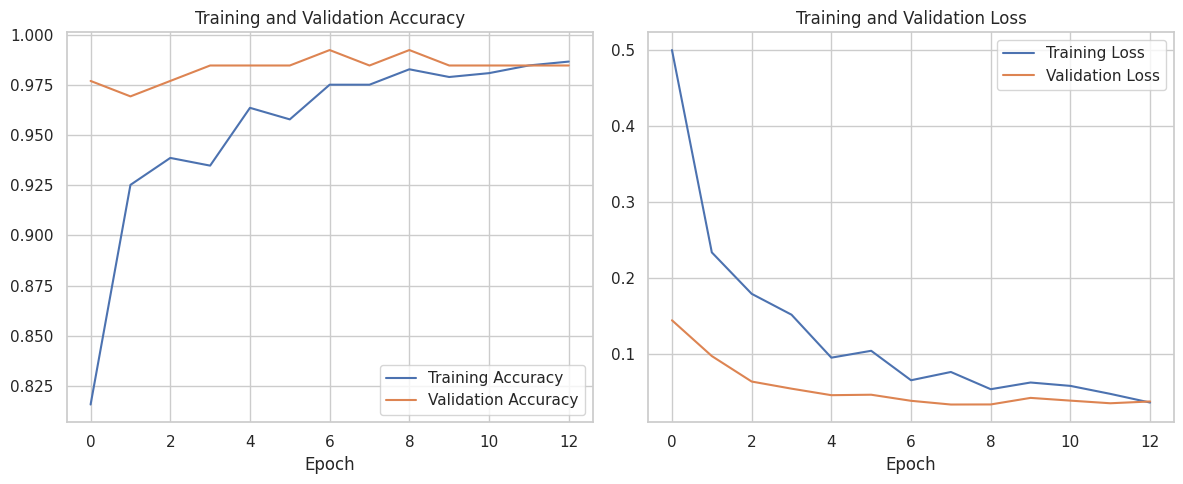

In [13]:
# Cell 9: Huấn luyện Model (Giai đoạn 1)

print("--- Starting Training Phase 1: Training Top Layers ---")

history = model.fit(
    train_ds,
    epochs=EPOCHS_TOP_LAYER,
    validation_data=val_ds,
    callbacks=callbacks_list
)

print("\n--- Finished Training Phase 1 ---")

# Vẽ đồ thị accuracy và loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) # Số epochs thực tế đã chạy (có thể ít hơn do EarlyStopping)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [14]:
# Cell 11: Đánh giá trên Tập Validation (Evaluate on Validation Set)

# Load lại model tốt nhất đã lưu từ checkpoint
# Đảm bảo biến MODEL_SAVE_PATH được định nghĩa đúng ở Cell 2
# (Thường là '/kaggle/working/fire_detection_resnet50_v2.h5')
print(f"\n--- Evaluating Best Model from Checkpoint: {MODEL_SAVE_PATH} ---")
try:
    # Load model đã lưu (bao gồm cả kiến trúc và trọng số)
    best_model = keras.models.load_model(MODEL_SAVE_PATH)
    print("Best model loaded successfully.")

    # Đánh giá model trên tập Validation
    # Lưu ý: Sử dụng val_ds đã được cấu hình với preprocess_input ở Cell 5
    print("\nEvaluating model on Validation data...")
    results = best_model.evaluate(val_ds, verbose=1) # Sử dụng val_ds

    print(f"\nValidation Loss: {results[0]:.4f}")
    print(f"Validation Accuracy: {results[1]:.4f}")

except FileNotFoundError:
    print(f"ERROR: Model file not found at {MODEL_SAVE_PATH}. Make sure training saved the model.")
except Exception as e:
    print(f"ERROR loading or evaluating model: {e}")

# --- Nếu bạn có tập Test (test_ds) riêng biệt, hãy dùng code này thay thế ---
# print("\n--- Evaluating Best Model on Test Set ---")
# try:
#     best_model = keras.models.load_model(MODEL_SAVE_PATH)
#     print("Best model loaded successfully.")
#     print("\nEvaluating model on Test data...")
#     # Đảm bảo test_ds đã được tạo và tiền xử lý ở các cell trước
#     results_test = best_model.evaluate(test_ds, verbose=1)
#     print(f"\nTest Loss: {results_test[0]:.4f}")
#     print(f"Test Accuracy: {results_test[1]:.4f}")
# except FileNotFoundError:
#     print(f"ERROR: Model file not found at {MODEL_SAVE_PATH}.")
# except NameError:
#     print("ERROR: test_ds not defined. Make sure you created a separate test dataset.")
# except Exception as e:
#     print(f"ERROR loading or evaluating model on test set: {e}")
# --- // ---


--- Evaluating Best Model from Checkpoint: /kaggle/working/fire_detection_resnet50_v2.h5 ---


Best model loaded successfully.

Evaluating model on Validation data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9918 - loss: 0.0377

Validation Loss: 0.0379
Validation Accuracy: 0.9923



--- Generating Classification Report and Confusion Matrix ---
Generating predictions on Validation data...
Found 651 files belonging to 2 classes.
Using 130 files for validation.
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       1.00      0.96      0.98       110

    accuracy                           0.97       130
   macro avg       0.92      0.98      0.95       130
weighted avg       0.97      0.97      0.97       130


Confusion Matrix (Validation Set):


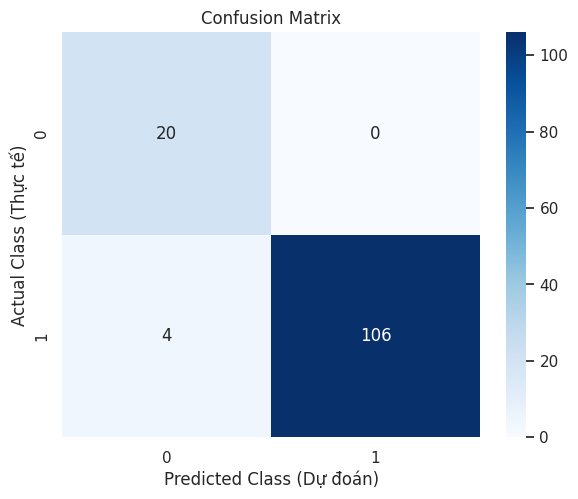

In [15]:
# Cell 12: Classification Report và Confusion Matrix (Trên Tập Validation)

# Đảm bảo bạn đã load thành công best_model ở Cell 11
if 'best_model' in locals() and best_model is not None:
    print("\n--- Generating Classification Report and Confusion Matrix ---")
    print("Generating predictions on Validation data...")

    # Tạo lại dataset validation không shuffle để lấy dự đoán theo đúng thứ tự nhãn
    # (Lưu ý: Lặp lại code tạo val_ds_no_shuffle từ trước nếu cần)
    try:
        val_ds_no_shuffle = tf.keras.utils.image_dataset_from_directory(
          data_dir, # Đường dẫn gốc tới thư mục dataset
          validation_split=0.2,
          subset="validation",
          seed=123, # Seed phải giống lúc chia train/val
          image_size=(IMG_SIZE, IMG_SIZE),
          batch_size=BATCH_SIZE, # Batch size có thể lớn hơn để tăng tốc predict
          label_mode='binary',
          shuffle=False # QUAN TRỌNG: Không shuffle
        )
        # Áp dụng tiền xử lý
        val_ds_no_shuffle = val_ds_no_shuffle.map(preprocess_image, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

        # Lấy nhãn thực tế
        y_true_list = []
        for images, labels in val_ds_no_shuffle:
            y_true_list.extend(labels.numpy())
        y_true = np.array(y_true_list).flatten().astype(int)

        # Lấy dự đoán xác suất từ model
        predictions_prob = best_model.predict(val_ds_no_shuffle, verbose=1)
        # Chuyển đổi xác suất thành lớp (0 hoặc 1)
        y_pred = (predictions_prob > 0.5).astype(int).flatten()

        # In báo cáo phân loại
        print("\nClassification Report (Validation Set):")
        # CLASS_NAMES_INFERRED được lấy từ Cell 3
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES_INFERRED))

        # Vẽ và hiển thị Confusion Matrix
        print("\nConfusion Matrix (Validation Set):")
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                    xticklabels=CLASS_NAMES_INFERRED, yticklabels=CLASS_NAMES_INFERRED)
        plt.ylabel('Actual Class (Thực tế)')
        plt.xlabel('Predicted Class (Dự đoán)')
        plt.title('Confusion Matrix')
        plt.show()

    except Exception as e:
        print(f"ERROR generating report/matrix: {e}")

else:
    print("\nSkipping Cell 12 because 'best_model' was not loaded successfully in Cell 11.")